#### Assignment 4

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import word2number as wn
import inflect

# Visualization Libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.subplots as sp
import plotly.graph_objects as go

# Finance Libraries
import yfinance as yf

# Timeseries Libraries
import pmdarima # Python wrapper for R's auto.arima
from statsmodels.tsa.stattools import adfuller, kpss, acf, q_stat
from statsmodels.tsa.seasonal import seasonal_decompose # Decomposition
from statsmodels.stats.diagnostic import kstest_normal, lilliefors, acorr_ljungbox, het_breuschpagan, het_arch
from statsmodels.compat import lzip
from arch.unitroot import PhillipsPerron
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet

# Machine Learning Libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error # Shared error metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Bidirectional
from keras.callbacks import EarlyStopping

In [2]:
# Silence Interpolation Warnings for displaying small p-values
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning
warnings.filterwarnings('ignore', category=InterpolationWarning)

In [3]:
def plot_histogram_qq(series):
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    # Plot histogram
    sns.histplot(series, ax=axes[0], kde=True)
    axes[0].set_title("Histogram")

    # Plot Q-Q plot
    stats.probplot(series, dist="norm", plot=axes[1])
    axes[1].set_title("Q-Q Plot")

    plt.tight_layout()
    plt.show()

In [4]:
def plot_acf_pacf(time_series):
    """
    Plots ACF and PACF plots for a given time series.
    
    Parameters:
        time_series (pd.Series): The input time series data.
    """
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot ACF
    plot_acf(time_series, ax=axes[0], lags=30)
    axes[0].set_title('Autocorrelation Function (ACF)')
    axes[0].set_ylim(-1.1, 1.1)  # Adjust the y-axis limits
    
    # Plot PACF
    plot_pacf(time_series, ax=axes[1], lags=30)
    axes[1].set_title('Partial Autocorrelation Function (PACF)')
    axes[1].set_ylim(-1.1, 1.1)  # Adjust the y-axis limits
    
    plt.tight_layout()
    plt.show()

In [5]:
def skew_and_kurtosis_confidence_intervals(timeseries):

    # Calculate n
    n = len(timeseries.dropna())

    # Calculate skew
    skew = timeseries.skew()
    SE_skew = np.sqrt((6*n*(n-1)) / ((n-2)*(n+1)*(n+3)))

    # Calculate kurtosis
    kurtosis = timeseries.kurtosis()
    SE_kurt = 2*SE_skew*np.sqrt((n**2-1)/(n-3))

    # Create dataframe with 95% confidence intervals
    normality_stats = pd.DataFrame({'Lower Bound':[skew - 1.96*SE_skew,kurtosis - 1.96*SE_kurt],
                                    'Data':[skew,kurtosis],
                                    'Upper Bound':[skew + 1.96*SE_skew,kurtosis + 1.96*SE_kurt]},
                                    index=['Skew','Kurtosis'])

    return(normality_stats)

In [6]:
def ComprehensiveTests(ts: pd.Series) -> pd.DataFrame:

    # Normality tests
    shapiro_stat, shapiro_p = stats.shapiro(ts)
    ks_stat, ks_p = stats.kstest(ts, 'norm', args=(ts.mean(), ts.std()))
    ad_result = stats.anderson(ts, dist='norm')
    jb_stat, jb_p = stats.jarque_bera(ts)
    ad_stat = ad_result.statistic
    ad_p = ad_result.critical_values[2]

    # Stationarity tests
    adf_stat, adf_p, _, _, _, _ = adfuller(ts)
    kpss_stat, kpss_p, _, _ = kpss(ts, nlags='auto', regression='c')
    pp_test = PhillipsPerron(ts)
    pp_stat = pp_test.stat
    pp_p = pp_test.pvalue

    # Autocorrelation tests
    ljung_box = acorr_ljungbox(ts, lags=1)
    ljung_box_stat = ljung_box.iloc[0, 0]
    ljung_box_p_value = ljung_box.iloc[0, 1]
    box_pierce_stat, box_pierce_p_value = q_stat(acf(ts, nlags=10, fft=True), len(ts))

    # Variance tests
    X = np.vstack([np.ones(len(ts)), range(len(ts))]).T
    bp_test_stat, bp_test_p_value, _, _ = het_breuschpagan(ts, X)
    ml_test_stat, ml_test_p_value, _, _ = het_arch(ts)
    
    # Determine results for each test
    shapiro_result = 'Normal' if shapiro_p > 0.05 else 'Non-Normal'
    ks_result = 'Normal' if ks_p > 0.05 else 'Non-Normal'
    ad_result = 'Normal' if ad_stat < ad_p else 'Non-Normal'
    jb_result = 'Normal' if jb_p > 0.05 else 'Non-Normal'
    adf_result = 'Stationary' if adf_p < 0.05 else 'Non-Stationary'
    kpss_result = 'Stationary' if kpss_p > 0.05 else 'Non-Stationary'
    pp_result = 'Stationary' if pp_p > 0.05 else 'Non-Stationary'
    ljung_box_result = 'Autocorrelated' if ljung_box_p_value < 0.05 else 'Non-Autocorrelated'
    box_pierce_result = 'Autocorrelated' if box_pierce_p_value[0] < 0.05 else 'Non-Autocorrelated'
    bp_result = 'Homoskedastic' if bp_test_p_value > 0.05 else 'Heteroskedastic'
    ml_result = 'Homoskedastic' if ml_test_p_value > 0.05 else 'Heteroskedastic'
    
    # Compile results
    Results = pd.DataFrame({
        'Test Name': ['Shapiro-Wilk', 'Kolmogorov-Smirnov', 'Anderson-Darling', 'Jarque-Bera', 'Augmented Dickey-Fuller', 'Kwiatkowski-Phillips-Schmidt-Shin', 'Phillips-Perron',
                    'Ljung-Box', 'Box-Pierce', 'Breusch-Pagan', 'McLeod-Li'],
        'Type': ['Normality', 'Normality', 'Normality', 'Normality', 'Stationarity', 'Stationarity', 'Stationarity', 
                'Autocorrelation', 'Autocorrelation', 'Variance', 'Variance'],
        'Test Statistic': [shapiro_stat, ks_stat, ad_stat, jb_stat, adf_stat, kpss_stat, pp_stat, 
                        ljung_box_stat, box_pierce_stat[0], bp_test_stat, ml_test_stat],
        'p-value': [shapiro_p, ks_p, np.nan, jb_p, adf_p, kpss_p, pp_p, 
                    ljung_box_p_value, box_pierce_p_value[0], bp_test_p_value, ml_test_p_value],
        'Result': [shapiro_result, ks_result, ad_result, jb_result,
        adf_result, kpss_result, pp_result, ljung_box_result,box_pierce_result,
        bp_result,ml_result]
    })
    
    return Results.round(3)

In [7]:
def decomposition(timeseries):

    timeseries_copy = timeseries.copy(deep=True)
    timeseries_copy = timeseries_copy.resample('D').ffill()
    decomp = seasonal_decompose(timeseries_copy)

    fig = make_subplots(rows=1,cols=3,subplot_titles=('Trend','Seasonal','Residuals'))

    fig.add_trace(px.line(decomp.trend).data[0],row=1,col=1)
    fig.add_trace(px.line(decomp.seasonal).data[0],row=1,col=2)
    fig.add_trace(px.line(decomp.resid).data[0],row=1,col=3)

    fig.update_layout(width=1950)

    fig.show()

In [8]:
def compute_error_metrics(y_true_1, y_true_2, y_preds, n=0):
    def MAPE(true, pred):
        true, pred = np.array(true), np.array(pred)
        return np.mean(np.abs((true - pred) / true)) * 100
    
    metrics_data = []

    for index, y_pred in enumerate(y_preds):
        # Use y_true_2 for the 5th, 10th, and 15th y_pred values
        if index+1 in [5, 10, 15]:
            Y_test = y_true_2
        else:
            Y_test = y_true_1
        
        MSE = mean_squared_error(Y_test, y_pred)
        RMSE = np.sqrt(MSE)
        MAE = mean_absolute_error(Y_test, y_pred)
        mape = MAPE(Y_test, y_pred)
        
        metrics_data.append([MSE, RMSE, MAE, mape])
    
    df = pd.DataFrame(metrics_data, columns=['MSE', 'RMSE', 'MAE', 'MAPE'])
    
    # Adding "Model" column
    df.insert(0, "Model", ["model_" + inflect.engine().number_to_words(i+1+n) for i in range(len(y_preds))])
    
    return df.round(2)

In [9]:
def univariate_predictions_to_dataframe(y_true, y_preds):

    # Initialize dictionary for DataFrame
    df_dict = {'y_true': list(y_true)}
    
    # Add each prediction series to the dictionary with appropriate name
    for i, y_pred in enumerate(y_preds, start=1):
        column_name = f"model_{inflect.engine().number_to_words(i)}"
        df_dict[column_name] = list(y_pred)

    # Convert dictionary to DataFrame
    df = pd.DataFrame(df_dict)
    
    return df

In [10]:
def plot_spectral_density(time_series):
    # Compute FFT and frequencies
    sp = np.fft.fft(time_series)
    freq = np.fft.fftfreq(len(time_series))
    
    # Only consider the positive frequencies (real)
    mask = freq > 0

    # Convert frequencies to periods (days)
    periods = 1 / freq[mask]

    # Plot the power spectrum with periods
    plt.figure(figsize=(10, 5))
    plt.plot(periods, np.abs(sp[mask])**2)
    plt.title('Power Spectrum')
    plt.xlabel('Period (days)')
    plt.ylabel('Power')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
def create_multivariate_dataset(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        if seq_length == 1:
            x.append([seq[0]])  # make it a 2D array even if seq_length is 1
        else:
            x.append(seq[:-1])
        y.append(seq[-1])
    return np.array(x), np.array(y)

In [12]:
def create_univariate_dataset(dataset, look_back=10):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [13]:
def timeseries_summary_statistics(*time_series):
    # Initialize a list to store results
    results = []
    
    for series in time_series:
        
        # Calculate statistics for the series
        min_val = series.min()
        max_val = series.max()
        percent_change = (series.iloc[-1] - series.iloc[0]) / series.iloc[0] * 100
        std_dev = series.std()
        
        results.append({
            'min': min_val,
            'max': max_val,
            'percent_change': percent_change,
            'std_dev': std_dev
        })
    
    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(results)
    
    return df.round(3)

In [14]:
def plot_rolling_volatility_and_correlation(names, window_length, *time_series):
    # Dataframe to hold rolling volatilities
    vol_df = pd.DataFrame()

    # Validate if the number of names matches the number of time series
    if len(names) != len(time_series):
        raise ValueError("The number of names should match the number of time series provided.")

    for idx, series in enumerate(time_series):
        # Calculate rolling volatility (standard deviation of returns)
        returns = series.pct_change().dropna()  # Calculate returns
        vol = returns.rolling(window_length).std()  # Calculate rolling volatility
        vol_df[names[idx]] = vol  # Add to dataframe

    # Calculate correlation between rolling volatilities
    correlation_df = vol_df.corr()

    # Plot using Plotly Express
    fig = px.line(vol_df, title=f'Rolling Volatility ({window_length}-day window)')
    fig.show()

    return correlation_df.round(2)

In [15]:
def compute_results(y_true_1, y_true_2, y_preds, histories, patience):
    def MAPE(true, pred):
        true, pred = np.array(true), np.array(pred)
        return np.mean(np.abs((true - pred) / true)) * 100
    
    metrics_data = []

    for index, y_pred in enumerate(y_preds):
        # Use y_true_2 for the 5th, 10th, and 15th y_pred values
        if index+1 in [5, 10, 15]:
            Y_test = y_true_2
        else:
            Y_test = y_true_1
        
        MSE = mean_squared_error(Y_test, y_pred)
        RMSE = np.sqrt(MSE)
        MAE = mean_absolute_error(Y_test, y_pred)
        mape = MAPE(Y_test, y_pred)

        # Extract the training and validation metrics for the last epoch
        last_epoch = len(histories[index].history['loss']) - patience
        train_acc = histories[index].history['accuracy'][last_epoch]
        train_loss = histories[index].history['loss'][last_epoch]
        val_acc = histories[index].history['val_accuracy'][last_epoch]
        val_loss = histories[index].history['val_loss'][last_epoch]

        metrics_data.append([last_epoch+1, train_acc, train_loss, val_acc, val_loss, MSE, RMSE, MAE, mape])

    df = pd.DataFrame(metrics_data, columns=['epoch', 'train_acc', 'train_loss', 'val_acc', 'val_loss', 'MSE', 'RMSE', 'MAE', 'MAPE'])

    # Adding "Model" column
    df.insert(0, "Model", ["model_" + inflect.engine().number_to_words(i+1) for i in range(len(y_preds))])
    
    return df.round(3)

In [16]:
def plot_training_history(history_list, n):
    total_plots = 10  # 2 rows x 5 columns
    fig, axes = plt.subplots(2, 5, figsize=(25, 8))

    for i, history in enumerate(history_list):
        row_idx = i // 5
        col_idx = i % 5

        training_accuracy = history.history['accuracy']
        validation_accuracy = history.history['val_accuracy']
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']

        # Plot training accuracy against validation accuracy
        line1, = axes[row_idx, col_idx].plot(training_accuracy, label='Training Accuracy')
        line2, = axes[row_idx, col_idx].plot(validation_accuracy, label='Validation Accuracy')
        axes[row_idx, col_idx].set_xlabel('Epochs')
        axes[row_idx, col_idx].set_ylabel('Accuracy')
        axes[row_idx, col_idx].set_title(f'Model {n + i + 1} Accuracy')

        # Plot training loss against validation loss
        line3, = axes[row_idx + 1, col_idx].plot(training_loss, label='Training Loss')
        line4, = axes[row_idx + 1, col_idx].plot(validation_loss, label='Validation Loss')
        axes[row_idx + 1, col_idx].set_xlabel('Epochs')
        axes[row_idx + 1, col_idx].set_ylabel('Loss')
        axes[row_idx + 1, col_idx].set_title(f'Model {n + i + 1} Loss')

    # Hide the unused axes if the number of histories is less than 5
    if len(history_list) < 5:
        for i in range(len(history_list), 5):
            axes[0, i].axis('off')  # Hiding the accuracy plot
            axes[1, i].axis('off')  # Hiding the loss plot

    # Add one legend for the entire figure
    fig.legend(handles=[line1, line2, line3, line4], loc='upper center', ncol=4)

    # Adjust layout and display the plots
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [105]:
def analyze_results(results_df):

    rnn = results_df.query('`type`=="RNN"')
    lstm = results_df.query('`type`=="LSTM"')
    gru = results_df.query('`type`=="GRU"')

    results = pd.DataFrame(
        {
            'model_type':['RNN','LSTM','GRU'],
            'min_MSE':[rnn.loc[:,'MSE'].min(),lstm.loc[:,'MSE'].min(),gru.loc[:,'MSE'].min()],
            'max_MSE':[rnn.loc[:,'MSE'].max(),lstm.loc[:,'MSE'].max(),gru.loc[:,'MSE'].max()]
        }
    )

    return(results)

#### Retrieve tickers

In [17]:
nikkei = yf.ticker.Ticker('EWJ') # Nikkei 225 - EWJ
hang_seng = yf.ticker.Ticker('EWH') # Hang Seng - EWH
csi = yf.ticker.Ticker('PEK') # CSI 300 - PEK
kospi = yf.ticker.Ticker('EWY') # Kospi Composite - EWY

In [18]:
ticker_list = ['EWJ','EWH','PEK','EWY']
index_list = ['Nikkei','Hang Seng','CSI','Kospi']
ticker_index_list = ['EWJ - Nikkei','EWH - Hang Seng','PEK - CSI','EWY - KOSPI']

#### Retrieve ticker history

In [19]:
nikkei_history = nikkei.history(start='2016-01-01',end='2018-01-01')
hang_seng_history = hang_seng.history(start='2016-01-01',end='2018-01-01')
csi_history = csi.history(start='2016-01-01',end='2018-01-01')
kospi_history = kospi.history(start='2016-01-01',end='2018-01-01')

#### Retrieve ticker price history

In [20]:
nikkei_price = nikkei_history.loc[:,'Close']
hang_seng_price = hang_seng_history.loc[:,'Close']
csi_price = csi_history.loc[:,'Close']
kospi_price = kospi_history.loc[:,'Close']

#### EDA

In [21]:
# Line Plots

fig = make_subplots(rows=2,cols=2,subplot_titles=ticker_index_list,vertical_spacing=0.15,horizontal_spacing=0.05)

fig.add_trace(px.line(nikkei_price).data[0],row=1,col=1)
fig.add_trace(px.line(hang_seng_price).data[0],row=1,col=2)
fig.add_trace(px.line(csi_price).data[0],row=2,col=1)
fig.add_trace(px.line(kospi_price).data[0],row=2,col=2)

fig.update_layout(height=800,width=1950)

fig.show()

In [22]:
# Line plot of normalize prices

closing_prices = pd.DataFrame({
    'EWJ - Nikkei':nikkei_price,
    'EWH - Hang Seng':hang_seng_price,
    'PEK - CSI':csi_price,
    'EWY - KOSPI':kospi_price})

min_max_scaler = MinMaxScaler()

min_max_scaler.fit(closing_prices)

noramlized_closing_prices = pd.DataFrame(min_max_scaler.transform(closing_prices),index=nikkei_price.index)

noramlized_closing_prices.columns = closing_prices.columns

display(px.line(closing_prices),px.line(noramlized_closing_prices))

In [23]:
summary_statistics = timeseries_summary_statistics(nikkei_price,hang_seng_price,csi_price,kospi_price)

summary_statistics['ticker'] = ticker_list
summary_statistics['index'] = index_list

summary_statistics.iloc[:,[4,5,0,1,2,3]]

,ticker,index,min,max,percent_change,std_dev
0,EWJ,Nikkei,36.618,55.182,29.730,4.283
1,EWH,Hang Seng,13.445,21.846,41.371,2.166
2,PEK,CSI,23.943,37.047,22.956,2.908
3,EWY,Kospi,40.327,69.679,60.961,7.977


In [24]:
plot_rolling_volatility_and_correlation(ticker_index_list,5,nikkei_price,hang_seng_price,csi_price,kospi_price)

,EWJ - Nikkei,EWH - Hang Seng,PEK - CSI,EWY - KOSPI
EWJ - Nikkei,1.00,0.68,0.56,0.55
EWH - Hang Seng,0.68,1.00,0.50,0.71
PEK - CSI,0.56,0.50,1.00,0.37
EWY - KOSPI,0.55,0.71,0.37,1.00


In [25]:
px.line(nikkei_price)

#### Univariate Preprocessing

In [26]:
# Provided code
training, test = train_test_split(nikkei_price, test_size=0.25, shuffle=False)

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
training_scaled = scaler.fit_transform(training.values.reshape(-1, 1))
test_scaled = scaler.transform(test.values.reshape(-1, 1))

look_back = 1
X_train, y_train = create_univariate_dataset(training_scaled, look_back)
X_test, y_test = create_univariate_dataset(test_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

look_back = 5
X_train_5, y_train_5 = create_univariate_dataset(training_scaled, look_back)
X_test_5, y_test_5 = create_univariate_dataset(test_scaled, look_back)

# Reshape input to be [samples, time steps, features]
X_train_5 = np.reshape(X_train_5, (X_train_5.shape[0], 1, X_train_5.shape[1]))
X_test_5 = np.reshape(X_test_5, (X_test_5.shape[0], 1, X_test_5.shape[1]))

# Create y_true series for seq lengths 1 and 5
nikkei_test_1 = nikkei_price[-len(X_test)-1:-1]
nikkei_test_5 = nikkei_price[-len(X_test_5)-1:-1]

#### Univariate Models

In [27]:
patience = 20
early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=0, restore_best_weights=True)

In [28]:
# Model One
model_one = Sequential()
model_one.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_one.add(Dense(1))
model_one.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_one.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_one = model_one.history
pred_one = model_one.predict(X_test)
pred_one = scaler.inverse_transform(pred_one)


4/4 [==============================] - 0s 740us/step


In [29]:
# Model Two
model_two = Sequential()
model_two.add(Bidirectional(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2]))))
model_two.add(Dense(1))
model_two.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_two.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_two = model_two.history
pred_two = model_two.predict(X_test)
pred_two = scaler.inverse_transform(pred_two)

4/4 [==============================] - 0s 790us/step


In [30]:
# Model Three
model_three = Sequential()
model_three.add(Bidirectional((SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2]),recurrent_dropout=0.2))))
model_three.add(Dense(1))
model_three.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_three.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_three = model_three.history
pred_three = model_three.predict(X_test)
pred_three = scaler.inverse_transform(pred_three)

4/4 [==============================] - 0s 765us/step


In [31]:
# Model Four
model_four = Sequential()
model_four.add(Bidirectional((SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),recurrent_dropout=0.2))))
model_four.add(Bidirectional((SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2]),recurrent_dropout=0.2))))
model_four.add(Dense(1))
model_four.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_four.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_four = model_four.history
pred_four = model_four.predict(X_test)
pred_four = scaler.inverse_transform(pred_four)

4/4 [==============================] - 0s 851us/step


In [78]:
# Model Five
model_five = Sequential()
model_five.add(Bidirectional((SimpleRNN(50, return_sequences=True, input_shape=(X_train_5.shape[1], X_train_5.shape[2]),recurrent_dropout=0.2))))
model_five.add(Bidirectional((SimpleRNN(50, input_shape=(X_train_5.shape[1], X_train_5.shape[2]),recurrent_dropout=0.2))))
model_five.add(Dense(1))
model_five.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_five.fit(X_train_5, y_train_5, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_five = model_five.history
pred_five = model_five.predict(X_test_5)
pred_five = scaler.inverse_transform(pred_five)

4/4 [==============================] - 0s 886us/step


In [79]:
# Model Six
model_six = Sequential()
model_six.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_six.add(Dense(1))
model_six.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_six.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_six = model_six.history
pred_six = model_one.predict(X_test)
pred_six = scaler.inverse_transform(pred_six)


4/4 [==============================] - 0s 620us/step


In [80]:
# Model Seven
model_seven = Sequential()
model_seven.add(Bidirectional(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]))))
model_seven.add(Dense(1))
model_seven.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_seven.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_seven = model_seven.history
pred_seven = model_seven.predict(X_test)
pred_seven = scaler.inverse_transform(pred_seven)

4/4 [==============================] - 0s 837us/step


In [81]:
# Model Eight
model_eight = Sequential()
model_eight.add(Bidirectional((LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]),recurrent_dropout=0.2))))
model_eight.add(Dense(1))
model_eight.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_eight.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_eight = model_eight.history
pred_eight = model_eight.predict(X_test)
pred_eight = scaler.inverse_transform(pred_eight)

4/4 [==============================] - 0s 789us/step


In [82]:
# Model Nine
model_nine = Sequential()
model_nine.add(Bidirectional((LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),recurrent_dropout=0.2))))
model_nine.add(Bidirectional((LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]),recurrent_dropout=0.2))))
model_nine.add(Dense(1))
model_nine.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_nine.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_nine = model_nine.history
pred_nine = model_nine.predict(X_test)
pred_nine = scaler.inverse_transform(pred_nine)

4/4 [==============================] - 0s 1ms/step


In [83]:
# Model Ten
model_ten = Sequential()
model_ten.add(Bidirectional((LSTM(50, return_sequences=True, input_shape=(X_train_5.shape[1], X_train_5.shape[2]),recurrent_dropout=0.2))))
model_ten.add(Bidirectional((LSTM(50, input_shape=(X_train_5.shape[1], X_train_5.shape[2]),recurrent_dropout=0.2))))
model_ten.add(Dense(1))
model_ten.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_ten.fit(X_train_5, y_train_5, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_ten = model_ten.history
pred_ten = model_ten.predict(X_test_5)
pred_ten = scaler.inverse_transform(pred_ten)

4/4 [==============================] - 1s 1ms/step


In [84]:
# Model Eleven
model_eleven = Sequential()
model_eleven.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model_eleven.add(Dense(1))
model_eleven.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_eleven.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_eleven = model_eleven.history
pred_eleven = model_eleven.predict(X_test)
pred_eleven = scaler.inverse_transform(pred_eleven)

4/4 [==============================] - 0s 734us/step


In [85]:
# Model Twelve
model_twelve = Sequential()
model_twelve.add(Bidirectional(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2]))))
model_twelve.add(Dense(1))
model_twelve.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_twelve.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_twelve = model_twelve.history
pred_twelve = model_twelve.predict(X_test)
pred_twelve = scaler.inverse_transform(pred_twelve)

4/4 [==============================] - 0s 1ms/step


In [86]:
# Model Thirteen
model_thirteen = Sequential()
model_thirteen.add(Bidirectional((GRU(50, input_shape=(X_train.shape[1], X_train.shape[2]),recurrent_dropout=0.2))))
model_thirteen.add(Dense(1))
model_thirteen.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_thirteen.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_thirteen = model_thirteen.history
pred_thirteen = model_thirteen.predict(X_test)
pred_thirteen = scaler.inverse_transform(pred_thirteen)

4/4 [==============================] - 0s 918us/step


In [87]:
# Model Fourteen
model_fourteen = Sequential()
model_fourteen.add(Bidirectional((GRU(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),recurrent_dropout=0.2))))
model_fourteen.add(Bidirectional((GRU(50, input_shape=(X_train.shape[1], X_train.shape[2]),recurrent_dropout=0.2))))
model_fourteen.add(Dense(1))
model_fourteen.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_fourteen.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_fourteen = model_fourteen.history
pred_fourteen = model_fourteen.predict(X_test)
pred_fourteen = scaler.inverse_transform(pred_fourteen)

4/4 [==============================] - 0s 1ms/step


In [88]:
# Model Fifteen
model_fifteen = Sequential()
model_fifteen.add(Bidirectional((GRU(50, return_sequences=True, input_shape=(X_train_5.shape[1], X_train_5.shape[2]),recurrent_dropout=0.2))))
model_fifteen.add(Bidirectional((GRU(50, input_shape=(X_train_5.shape[1], X_train_5.shape[2]),recurrent_dropout=0.2))))
model_fifteen.add(Dense(1))
model_fifteen.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_fifteen.fit(X_train_5, y_train_5, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_fifteen = model_fifteen.history
pred_fifteen = model_fifteen.predict(X_test_5)
pred_fifteen = scaler.inverse_transform(pred_fifteen)

4/4 [==============================] - 0s 998us/step


#### Univariate Results

In [96]:
results = compute_results(
    nikkei_test_1,
    nikkei_test_5,
    [pred_one,pred_two,pred_three,pred_four,pred_five,pred_six,pred_seven,pred_eight,pred_nine,pred_ten,pred_eleven,pred_twelve,pred_thirteen,pred_fourteen,pred_fifteen],
    [history_one,history_two,history_three,history_four,history_five,history_six,history_seven,history_eight,history_nine,history_ten,history_eleven,history_twelve,history_thirteen,history_fourteen,history_fifteen],
    patience
)

results['type'] = ['RNN'] * 5 + ['LSTM'] * 5 + ['GRU'] * 5

results.iloc[:,[0,-1,1,2,3,4,5,6,7,8,9]]

,Model,type,epoch,train_acc,train_loss,val_acc,val_loss,MSE,RMSE,MAE,MAPE
0,model_one,RNN,38,0.003,0.001,0.013,0.001,0.218,0.466,0.411,4.522
1,model_two,RNN,61,0.003,0.001,0.013,0.001,0.161,0.401,0.355,4.543
2,model_three,RNN,81,0.003,0.001,0.013,0.001,0.244,0.494,0.438,4.522
3,model_four,RNN,24,0.003,0.001,0.013,0.001,0.527,0.726,0.593,4.387
4,model_five,RNN,81,0.003,0.001,0.013,0.000,0.282,0.531,0.384,4.222
5,model_six,LSTM,67,0.003,0.001,0.013,0.000,0.218,0.466,0.411,4.522
6,model_seven,LSTM,52,0.003,0.001,0.013,0.000,0.159,0.399,0.323,5.025
7,model_eight,LSTM,52,0.003,0.001,0.013,0.000,0.172,0.415,0.332,5.042
8,model_nine,LSTM,21,0.003,0.001,0.013,0.001,0.596,0.772,0.611,5.390
9,model_ten,LSTM,18,0.003,0.002,0.013,0.001,0.358,0.599,0.478,5.017


In [106]:
analyze_results(results)

,model_type,min_MSE,max_MSE
0,RNN,0.161,0.527
1,LSTM,0.159,0.596
2,GRU,0.015,0.035


In [107]:
results_df = univariate_predictions_to_dataframe(nikkei_test_5,[pred_one[4:],pred_two[4:],pred_three[4:],pred_four[4:],pred_five,pred_six[4:],pred_seven[4:],pred_eight[4:],pred_nine[4:],pred_ten,pred_eleven[4:],pred_twelve[4:],pred_thirteen[4:],pred_fourteen[4:],pred_fifteen])
for column in results_df.columns:
    results_df.loc[:,column] = results_df.loc[:,column].astype(float)
px.line(results_df,height=500)

/var/folders/hb/_tr1b6d918vdtcwmymd4p0v80000gn/T/ipykernel_16542/1366877939.py:3: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`



In [119]:
results_df_rnn = univariate_predictions_to_dataframe(nikkei_test_5,[pred_one[4:],pred_two[4:],pred_three[4:],pred_four[4:],pred_five])
results_df_lstm = univariate_predictions_to_dataframe(nikkei_test_5,[pred_six[4:],pred_seven[4:],pred_eight[4:],pred_nine[4:],pred_ten])
results_df_lstm.columns = ['y_true','model_six','model_seven','model_eight','model_nine','model_ten']
results_df_gru = univariate_predictions_to_dataframe(nikkei_test_5,[pred_eleven[4:],pred_twelve[4:],pred_thirteen[4:],pred_fourteen[4:],pred_fifteen])
results_df_gru.columns = ['y_true','model_eleven','model_twelve','model_thirteen','model_fourteen','model_fifteen']

for dataframe in [results_df_rnn,results_df_lstm,results_df_gru]:
    for column in dataframe.columns:
        dataframe[column] = dataframe[column].astype(float)

results_df_rnn_px = px.line(results_df_rnn)
results_df_lstm_px = px.line(results_df_lstm)
results_df_gru_px = px.line(results_df_gru)

fig = make_subplots(rows=1, cols=3, shared_yaxes=True, subplot_titles=('RNN','LSTM','GRU'))

for trace in results_df_rnn_px.data:
    fig.add_trace(trace, row=1, col=1)
    trace.showlegend = True

for trace in results_df_lstm_px.data:
    fig.add_trace(trace, row=1, col=2)
    trace.showlegend = True

for trace in results_df_gru_px.data:
    fig.add_trace(trace, row=1, col=3)
    trace.showlegend = True

fig.show()

In [ ]:
display(plot_training_history([history_one,history_two,history_three,history_four,history_five],0))
display(plot_training_history([history_six,history_seven,history_eight,history_nine,history_ten],5))
display(plot_training_history([history_eleven,history_twelve,history_thirteen,history_fourteen,history_fifteen],10))

#### Multivariate Preprocessing

In [225]:
# b. Normalize the data
multi_scaler = MinMaxScaler(feature_range=(0, 1))
multi_scaled_data = multi_scaler.fit_transform(closing_prices)

# c. Split data into training and testing
multi_train, multi_test = train_test_split(multi_scaled_data,test_size=0.25,shuffle=False)

multi_look_back = 1  # You can adjust this value as needed
multi_X_train, multi_y_train = create_multivariate_dataset(multi_train, multi_look_back)
multi_X_test, multi_y_test = create_multivariate_dataset(multi_test, multi_look_back)

multi_look_back = 5  # You can adjust this value as needed
multi_X_train_5, multi_y_train_5 = create_multivariate_dataset(multi_train, multi_look_back)
multi_X_test_5, multi_y_test_5 = create_multivariate_dataset(multi_test, multi_look_back)

# Create y_true series for seq lengths 1 and 5
multi_test_1 = closing_prices[-len(multi_X_test)-1:-1]
multi_test_5 = closing_prices[-len(multi_X_test_5)-1:-1]

#### Multivariate Models

In [226]:
patience = 20
early_stop = EarlyStopping(monitor='val_loss', patience=patience, verbose=0, restore_best_weights=True)

In [227]:
# Model One
model_one = Sequential()
model_one.add(SimpleRNN(50, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2])))
model_one.add(Dense(4))
model_one.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_one.fit(multi_X_train, multi_y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_one = model_one.history
pred_one = model_one.predict(multi_X_test)
pred_one = multi_scaler.inverse_transform(pred_one)

4/4 [==============================] - 0s 684us/step


In [228]:
# Model Two
model_two = Sequential()
model_two.add(Bidirectional(SimpleRNN(50, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2]))))
model_two.add(Dense(4))
model_two.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_two.fit(multi_X_train, multi_y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_two = model_two.history
pred_two = model_two.predict(multi_X_test)
pred_two = multi_scaler.inverse_transform(pred_two)

4/4 [==============================] - 0s 728us/step


In [229]:
# Model Three
model_three = Sequential()
model_three.add(Bidirectional((SimpleRNN(50, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2]),recurrent_dropout=0.2))))
model_three.add(Dense(4))
model_three.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_three.fit(multi_X_train, multi_y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_three = model_three.history
pred_three = model_three.predict(multi_X_test)
pred_three = multi_scaler.inverse_transform(pred_three)

4/4 [==============================] - 0s 809us/step


In [230]:
# Model Four
model_four = Sequential()
model_four.add(Bidirectional((SimpleRNN(50, return_sequences=True, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2]),recurrent_dropout=0.2))))
model_four.add(Bidirectional((SimpleRNN(50, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2]),recurrent_dropout=0.2))))
model_four.add(Dense(4))
model_four.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_four.fit(multi_X_train, multi_y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_four = model_four.history
pred_four = model_four.predict(multi_X_test)
pred_four = multi_scaler.inverse_transform(pred_four)

4/4 [==============================] - 0s 1ms/step


In [231]:
# Model Five
model_five = Sequential()
model_five.add(Bidirectional((SimpleRNN(50, return_sequences=True, input_shape=(multi_X_train_5.shape[1], multi_X_train_5.shape[2]),recurrent_dropout=0.2))))
model_five.add(Bidirectional((SimpleRNN(50, input_shape=(multi_X_train_5.shape[1], multi_X_train_5.shape[2]),recurrent_dropout=0.2))))
model_five.add(Dense(4))
model_five.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_five.fit(multi_X_train_5, multi_y_train_5, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_five = model_five.history
pred_five = model_five.predict(multi_X_test_5)
pred_five = multi_scaler.inverse_transform(pred_five)

4/4 [==============================] - 0s 1ms/step


In [232]:
# Model Six
model_six = Sequential()
model_six.add(LSTM(50, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2])))
model_six.add(Dense(4))
model_six.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_six.fit(multi_X_train, multi_y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_six = model_six.history
pred_six = model_one.predict(multi_X_test)
pred_six = multi_scaler.inverse_transform(pred_six)

4/4 [==============================] - 0s 692us/step


In [233]:
# Model Seven
model_seven = Sequential()
model_seven.add(Bidirectional(LSTM(50, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2]))))
model_seven.add(Dense(4))
model_seven.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_seven.fit(multi_X_train, multi_y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_seven = model_seven.history
pred_seven = model_seven.predict(multi_X_test)
pred_seven = multi_scaler.inverse_transform(pred_seven)

4/4 [==============================] - 0s 1ms/step


In [234]:
# Model Eight
model_eight = Sequential()
model_eight.add(Bidirectional((LSTM(50, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2]),recurrent_dropout=0.2))))
model_eight.add(Dense(4))
model_eight.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_eight.fit(multi_X_train, multi_y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_eight = model_eight.history
pred_eight = model_eight.predict(multi_X_test)
pred_eight = multi_scaler.inverse_transform(pred_eight)

4/4 [==============================] - 0s 835us/step


In [235]:
# Model Nine
model_nine = Sequential()
model_nine.add(Bidirectional((LSTM(50, return_sequences=True, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2]),recurrent_dropout=0.2))))
model_nine.add(Bidirectional((LSTM(50, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2]),recurrent_dropout=0.2))))
model_nine.add(Dense(4))
model_nine.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_nine.fit(multi_X_train, multi_y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_nine = model_nine.history
pred_nine = model_nine.predict(multi_X_test)
pred_nine = multi_scaler.inverse_transform(pred_nine)

4/4 [==============================] - 0s 1ms/step


In [236]:
# Model Ten
model_ten = Sequential()
model_ten.add(Bidirectional((LSTM(50, return_sequences=True, input_shape=(multi_X_train_5.shape[1], multi_X_train_5.shape[2]),recurrent_dropout=0.2))))
model_ten.add(Bidirectional((LSTM(50, input_shape=(multi_X_train_5.shape[1], multi_X_train_5.shape[2]),recurrent_dropout=0.2))))
model_ten.add(Dense(4))
model_ten.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_ten.fit(multi_X_train_5, multi_y_train_5, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_ten = model_ten.history
pred_ten = model_ten.predict(multi_X_test_5)
pred_ten = multi_scaler.inverse_transform(pred_ten)

4/4 [==============================] - 0s 2ms/step


In [237]:
# Model Eleven
model_eleven = Sequential()
model_eleven.add(GRU(50, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2])))
model_eleven.add(Dense(4))
model_eleven.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_eleven.fit(multi_X_train, multi_y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_eleven = model_eleven.history
pred_eleven = model_eleven.predict(multi_X_test)
pred_eleven = multi_scaler.inverse_transform(pred_eleven)

4/4 [==============================] - 0s 836us/step


In [238]:
# Model Twelve
model_twelve = Sequential()
model_twelve.add(Bidirectional(GRU(50, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2]))))
model_twelve.add(Dense(4))
model_twelve.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_twelve.fit(multi_X_train, multi_y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_twelve = model_twelve.history
pred_twelve = model_twelve.predict(multi_X_test)
pred_twelve = multi_scaler.inverse_transform(pred_twelve)

4/4 [==============================] - 2s 807us/step


In [239]:
# Model Thirteen
model_thirteen = Sequential()
model_thirteen.add(Bidirectional((GRU(50, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2]),recurrent_dropout=0.2))))
model_thirteen.add(Dense(4))
model_thirteen.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_thirteen.fit(multi_X_train, multi_y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_thirteen = model_thirteen.history
pred_thirteen = model_thirteen.predict(multi_X_test)
pred_thirteen = multi_scaler.inverse_transform(pred_thirteen)

4/4 [==============================] - 0s 965us/step


In [240]:
# Model Fourteen
model_fourteen = Sequential()
model_fourteen.add(Bidirectional((GRU(50, return_sequences=True, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2]),recurrent_dropout=0.2))))
model_fourteen.add(Bidirectional((GRU(50, input_shape=(multi_X_train.shape[1], multi_X_train.shape[2]),recurrent_dropout=0.2))))
model_fourteen.add(Dense(4))
model_fourteen.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_fourteen.fit(multi_X_train, multi_y_train, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_fourteen = model_fourteen.history
pred_fourteen = model_fourteen.predict(multi_X_test)
pred_fourteen = multi_scaler.inverse_transform(pred_fourteen)

4/4 [==============================] - 0s 1ms/step


In [241]:
# Model Fifteen
model_fifteen = Sequential()
model_fifteen.add(Bidirectional((GRU(50, return_sequences=True, input_shape=(multi_X_train_5.shape[1], multi_X_train_5.shape[2]),recurrent_dropout=0.2))))
model_fifteen.add(Bidirectional((GRU(50, input_shape=(multi_X_train_5.shape[1], multi_X_train_5.shape[2]),recurrent_dropout=0.2))))
model_fifteen.add(Dense(4))
model_fifteen.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model_fifteen.fit(multi_X_train_5, multi_y_train_5, epochs=100, batch_size=32, verbose=0, validation_split=0.2, callbacks=[early_stop])
history_fifteen = model_fifteen.history
pred_fifteen = model_fifteen.predict(multi_X_test_5)
pred_fifteen = multi_scaler.inverse_transform(pred_fifteen)

4/4 [==============================] - 0s 2ms/step


#### Multivariate Results

In [245]:
results = compute_results(
    multi_test_1,
    multi_test_5,
    [pred_one,pred_two,pred_three,pred_four,pred_five,pred_six,pred_seven,pred_eight,pred_nine,pred_ten,pred_eleven,pred_twelve,pred_thirteen,pred_fourteen,pred_fifteen],
    [history_one,history_two,history_three,history_four,history_five,history_six,history_seven,history_eight,history_nine,history_ten,history_eleven,history_twelve,history_thirteen,history_fourteen,history_fifteen],
    patience
)

results['type'] = ['RNN'] * 5 + ['LSTM'] * 5 + ['GRU'] * 5

results.iloc[:,[0,-1,1,2,3,4,5,6,7,8,9]]


,Model,type,epoch,train_acc,train_loss,val_acc,val_loss,MSE,RMSE,MAE,MAPE
0,model_one,RNN,81,0.957,0.000,0.934,0.000,0.624,0.790,0.560,1.121
1,model_two,RNN,69,0.987,0.000,0.961,0.000,0.543,0.737,0.603,1.358
2,model_three,RNN,81,0.990,0.000,0.961,0.000,0.726,0.852,0.673,1.431
3,model_four,RNN,15,0.977,0.000,1.000,0.001,5.813,2.411,1.930,4.222
4,model_five,RNN,72,0.741,0.002,0.960,0.001,1.750,1.323,1.004,2.331
5,model_six,LSTM,40,0.623,0.001,0.934,0.003,0.624,0.790,0.560,1.121
6,model_seven,LSTM,37,0.620,0.001,0.934,0.003,2.199,1.483,1.314,3.746
7,model_eight,LSTM,43,0.683,0.001,0.934,0.002,2.688,1.639,1.496,3.997
8,model_nine,LSTM,81,0.960,0.000,0.934,0.001,2.488,1.577,1.175,2.481
9,model_ten,LSTM,80,0.875,0.001,0.747,0.001,0.343,0.586,0.451,1.308


In [246]:
analyze_results(results)

,model_type,min_MSE,max_MSE
0,RNN,0.543,5.813
1,LSTM,0.343,2.688
2,GRU,0.028,0.690


In [247]:
preds = [pred_one[4:],pred_two[4:],pred_three[4:],pred_four[4:],pred_five,pred_six[4:],pred_seven[4:],pred_eight[4:],pred_nine[4:],pred_ten,pred_eleven[4:],pred_twelve[4:],pred_thirteen[4:],pred_fourteen[4:],pred_fifteen]

# Define a color mapping for the columns
color_map = {
    'EWJ - Nikkei': 'blue',
    'EWH - Hang Seng': 'red',
    'PEK - CSI': 'green',
    'EWY - KOSPI': 'orange',
    'pred_Nikkei': 'blue',
    'pred_HangSeng': 'red',
    'pred_CSI': 'green',
    'pred_Kospi': 'orange'
}

subplot_titles = ['model one','model six','model eleven','model two','model seven','model twelve','model three','model eight','model thirteen','model four','model nine','model fourteen','model five','model ten','model fifteen']

fig = make_subplots(rows=5, cols=3, subplot_titles=subplot_titles, vertical_spacing=0.05, horizontal_spacing=0.025)

positions = [(i, j) for i in range(1, 6) for j in range(1, 4)]

for idx, pred in enumerate(preds):
    pred_df = pd.DataFrame(pred)
    pred_df.columns = ['pred_Nikkei', 'pred_HangSeng', 'pred_CSI', 'pred_Kospi']
    pred_df.index = multi_test_5.index

    multi_results = multi_test_5.merge(pred_df, on='Date')

    results_scaler = MinMaxScaler()
    results_scaler.fit(multi_results)
    multi_results_normalized = pd.DataFrame(results_scaler.transform(multi_results), columns=multi_results.columns, index=multi_results.index)
    
    row = (idx % 5) + 1
    col = (idx // 5) + 1
    
    for column in multi_results_normalized.columns:
        fig.add_trace(
            go.Scatter(x=multi_results_normalized.index, y=multi_results_normalized[column], name=column, line=dict(color=color_map[column])),
            row=row, col=col
        )

fig.update_layout(height=1250,width=2000,showlegend=False)
fig.show()


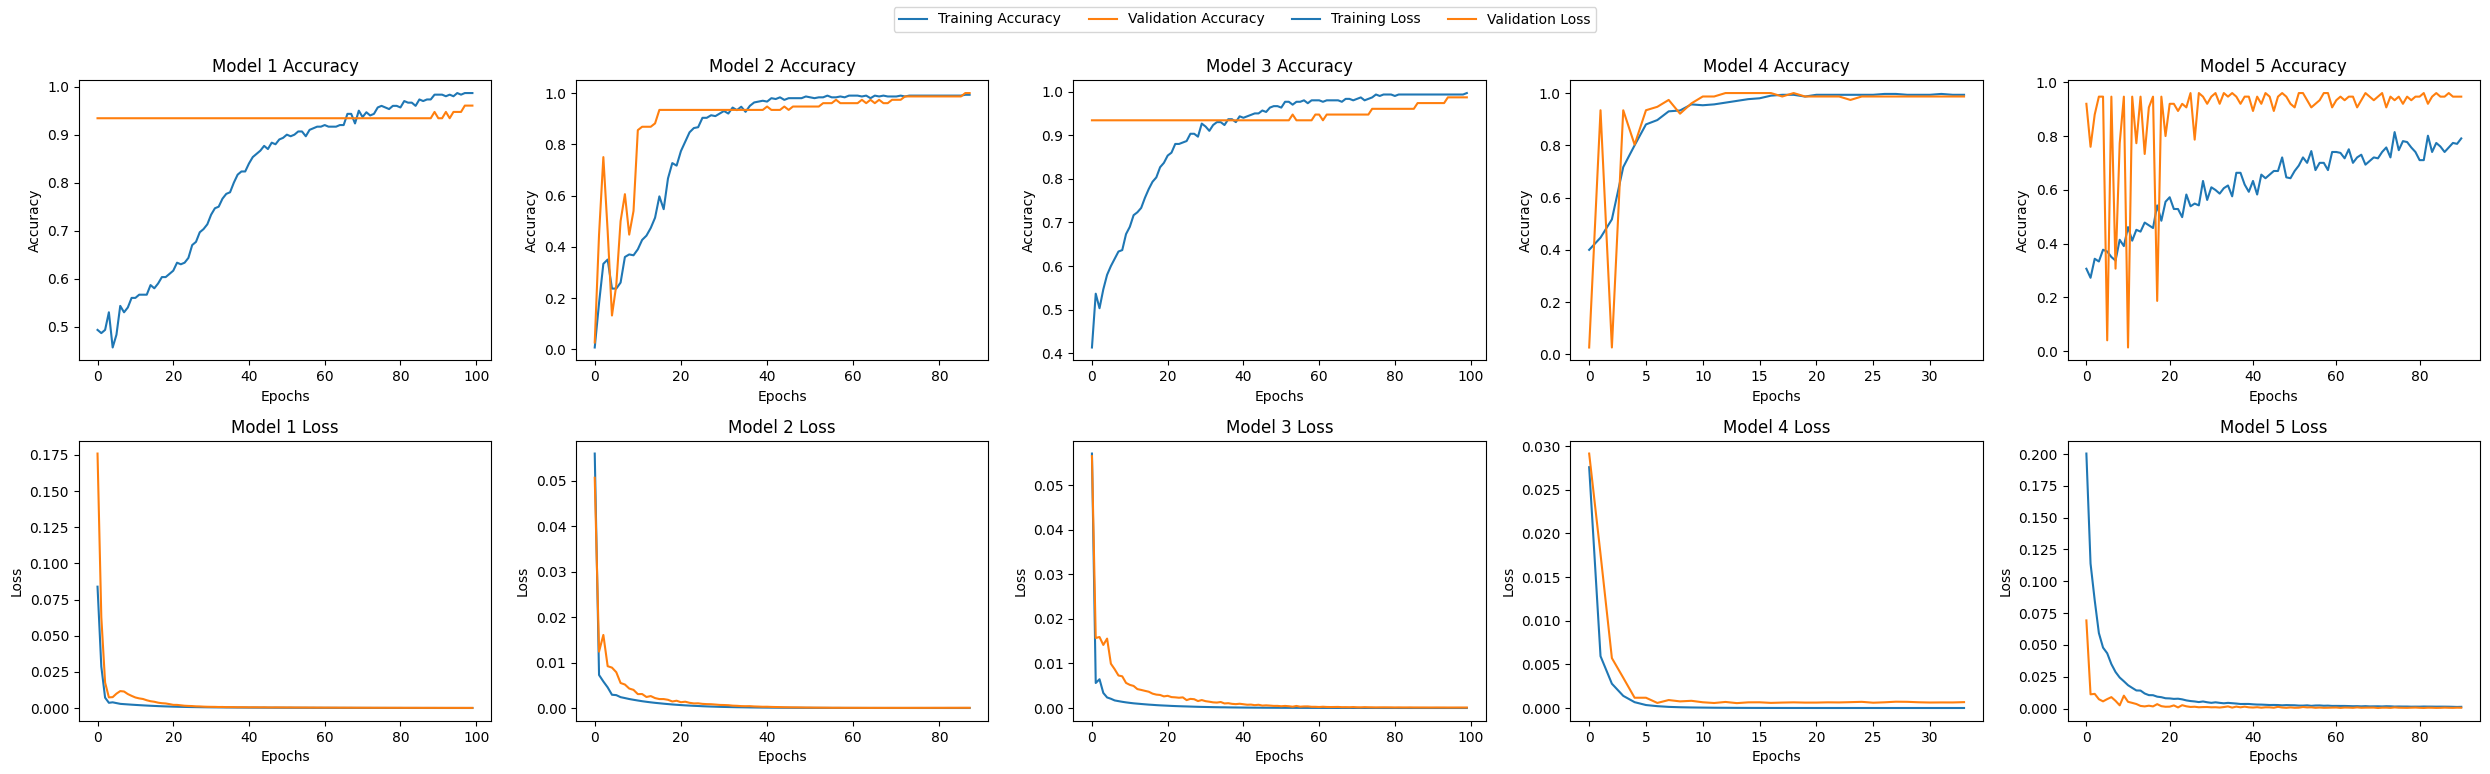

None

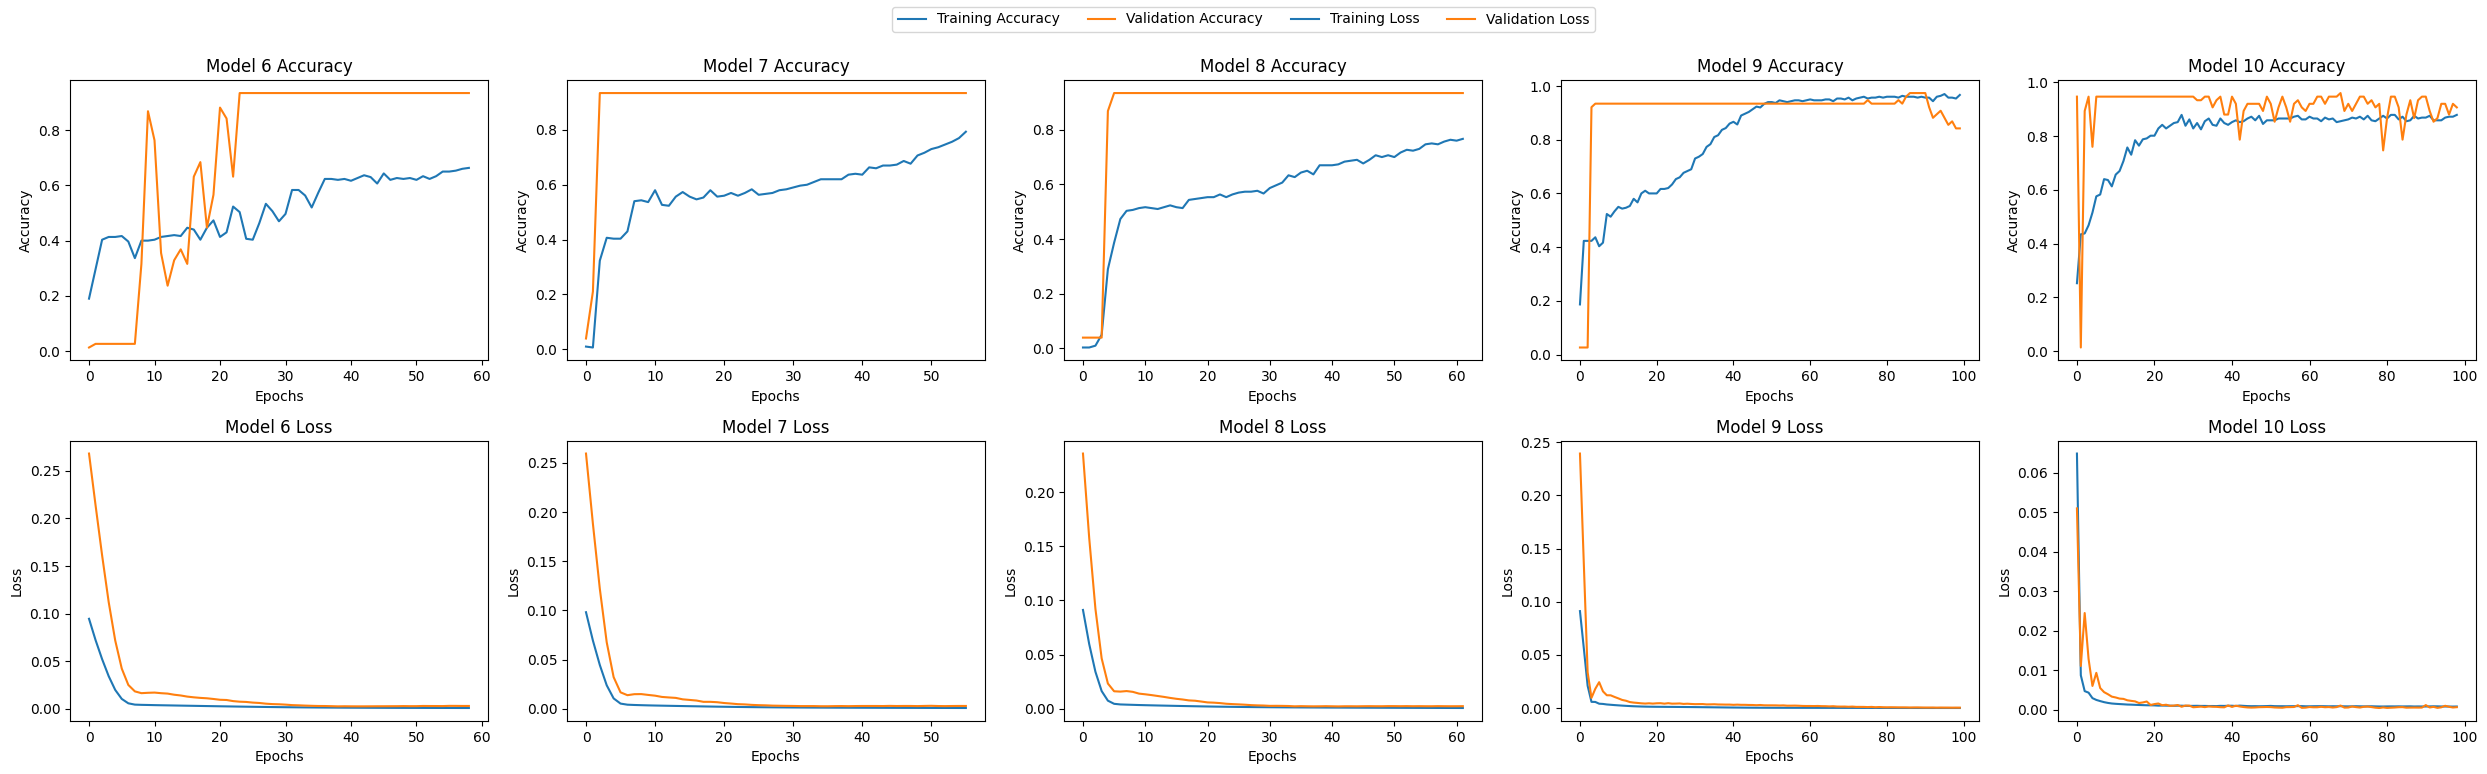

None

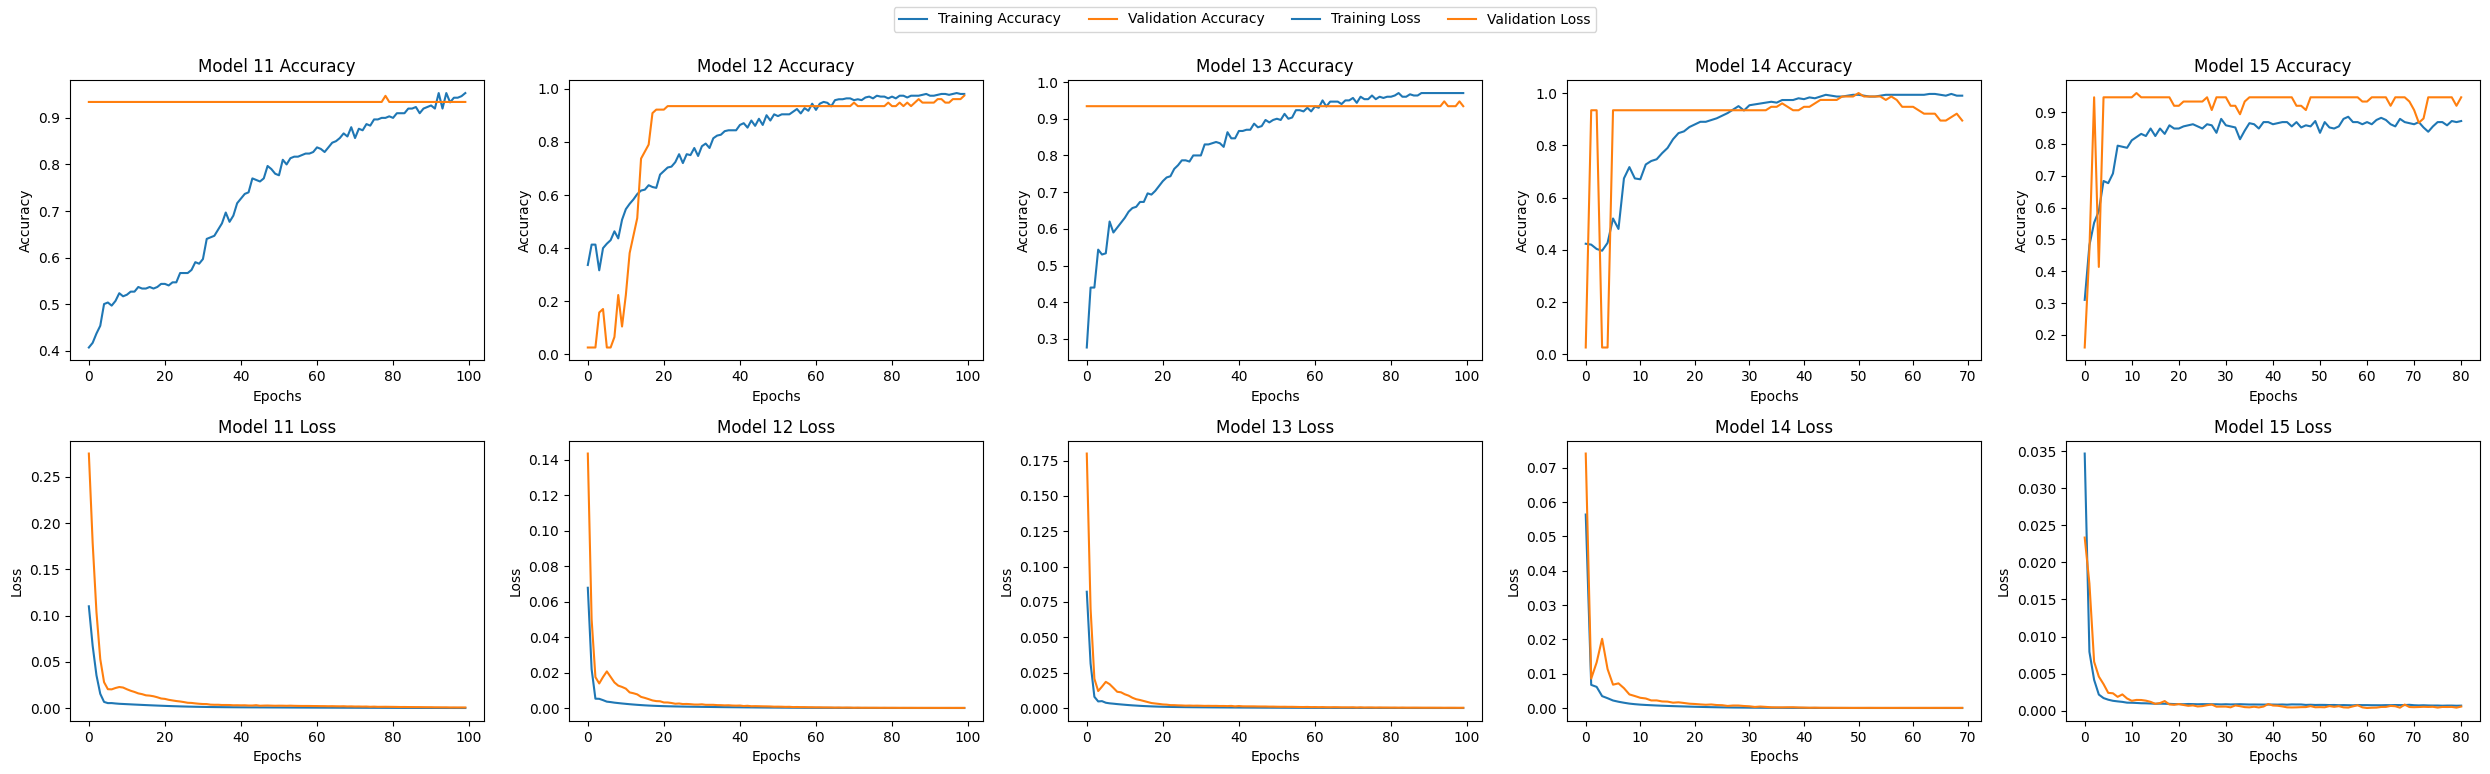

None

In [252]:
display(plot_training_history([history_one,history_two,history_three,history_four,history_five],0))
display(plot_training_history([history_six,history_seven,history_eight,history_nine,history_ten],5))
display(plot_training_history([history_eleven,history_twelve,history_thirteen,history_fourteen,history_fifteen],10))